# Práctica 2
# Clasificación no lineal, complejidad y sobreajuste
## [Introducción a los Sistemas Inteligentes](https://fagonzalezo.github.io/iis-2018-2/)
### Grupos de máximo 2 personas
### Entrega: Jueves 4 de Octubre 2018


Siguiendo con el uso del conjunto de datos **Wine** usado en la práctica anterior:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from sklearn import datasets
from sklearn.datasets import make_moons
import graphviz 
from sklearn.tree import export_graphviz
import pydot


# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Función para visualizar de la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun):
    print(X.shape)
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun


### 1. Cargamos el conjunto de datos **Wine** como un DataFrame de pandas.

In [3]:
import pandas as pd
wine_df = pd.read_csv('wine.data.txt')
wine_df.head()

,Class,Alcohol,Malic_acid,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoid,Proanthocyanins,Color,Hue,OD280/OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


#### 1.1 Se carga la clase aparte y se elimina de panda

In [4]:
#Se separa la columna y el valor se agrega al arreglo de resultados
clase = wine_df['Class']
clase_arr = []
color_arr =[]
print(type(clase))
for e in clase:
    clase_arr.append(e)
    if e==1:
        color_arr.append("black")
    elif e==2:
        color_arr.append("yellow")
    else:
        color_arr.append("red")
    #print(e)
print(len(clase_arr))
wine_df_full_hd = wine_df.drop(columns=["Class"])
#remove the white spaces in the columns 
wine_df_full_hd.columns = wine_df_full_hd.columns.str.strip()

<class 'pandas.core.series.Series'>
178


### 2. Generamos una partición estratificada 70-30 sobre el conjunto de datos cargados.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(wine_df_full_hd, clase_arr,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=clase_arr)


### 3. Generamos una gráfica de barras en Pandas que verifique que las particiones de entrenamiento y probamos tengan la misma distribución de clases.

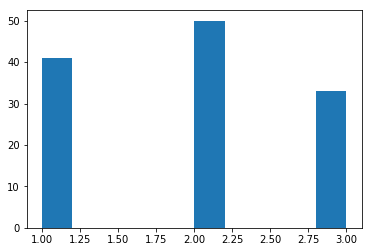

In [8]:
pl.hist(y_train)
pl.show()

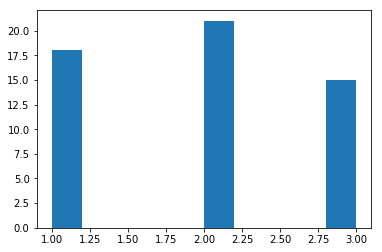

In [9]:
pl.hist(y_test)
pl.show()

In [10]:
print('Número de muestras en entrenamiento: {}'.format(X_train.shape[0]))
print('Número de muestras en prueba: {}'.format(X_test.shape[0]))
print('Número de características: {}'.format(X_train.shape[1]))

print('Distribución de clases en entrenamiento: {}'.format(np.bincount(y_train)))
print('Distribución de clases en prueba: {}'.format(np.bincount(y_test)))

Número de muestras en entrenamiento: 124
Número de muestras en prueba: 54
Número de características: 13
Distribución de clases en entrenamiento: [ 0 41 50 33]
Distribución de clases en prueba: [ 0 18 21 15]


## Explorando la complejidad usando `KNearestNeighbor`

### 4. Entrenamos un modelo `KNearestNeighbor`. Usamos los siguientes valores para evaluar la complejidad:###
   * $[1, 2, 3, \dots, 20]$
   * Graficamos los errores de entrenamiento y generalización conforme a la complejidad el modelo aumenta.

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
k_values = list(range(4, 25))
print(k_values)

[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [13]:
train_error = []
generalization_error = []

for nn in k_values:
    knn = KNeighborsClassifier(n_neighbors=nn)
    knn.fit(X_train, y_train)
    train_error.append(1 - knn.score(X_train, y_train))
    generalization_error.append(1 - knn.score(X_test, y_test))

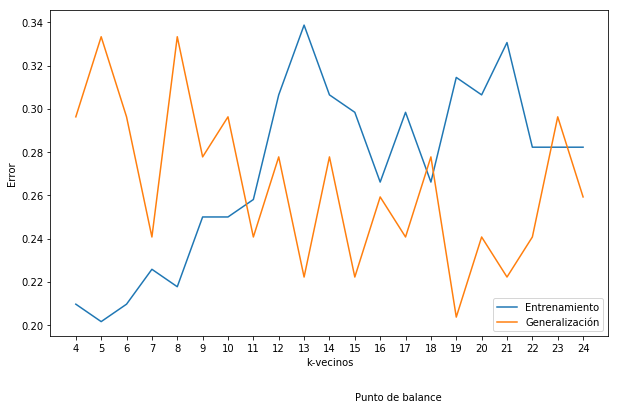

In [14]:
pl.figure(figsize = (10, 6))

pl.plot(k_values, train_error, label="Entrenamiento")
pl.plot(k_values, generalization_error, label="Generalización")
pl.xticks(k_values)
pl.xlabel("k-vecinos")
pl.ylabel("Error")
#pl.gca().invert_xaxis()
pl.arrow(13, 0.16, 0, -0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
pl.text(15, 0.165, 'Punto de balance')
pl.legend();

#### Eligiendo K= 19 da el mejor modelo con el mejor rendimiento para la generalización.

### 5. Construimos un conjunto de datos usando las características `Proline` contra `Flavonoids`. 
   * Usamos la partición 70-30 definida al inicio
   * Usando `KNearestNeighbor`, determinamos el número óptimo de k-vecinos usando evaluación de la complejidad. Use los mismos valores de $k$: $[1, 2, 3, \dots, 20]$
   * Graficamos la superficie de decisión contra los ejemplos de test.
   * Reportamos accuracy, el error de clasificación, la precisión macro, el recall macro y el F1 score macro sobre el **conjunto de prueba**.

#### Separacion de caracteristicas Proline y Flavanoids

In [15]:
proline= wine_df_full_hd['Proline']
flavanoids = wine_df_full_hd['Flavanoids']


In [16]:
#Se crea la matriz X
X=[]
for i in range(len(proline)):
    X.append([proline[i], flavanoids[i] ])
X= np.matrix(X)

#### Particion 70 30

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, clase_arr,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=clase_arr)


#### Numero optimo de K vecinos

In [18]:
k_values = list(range(4, 25))
train_error = []
generalization_error = []

for nn in k_values:
    knn = KNeighborsClassifier(n_neighbors=nn)
    knn.fit(X_train, y_train)
    train_error.append(1 - knn.score(X_train, y_train))
    generalization_error.append(1 - knn.score(X_test, y_test))

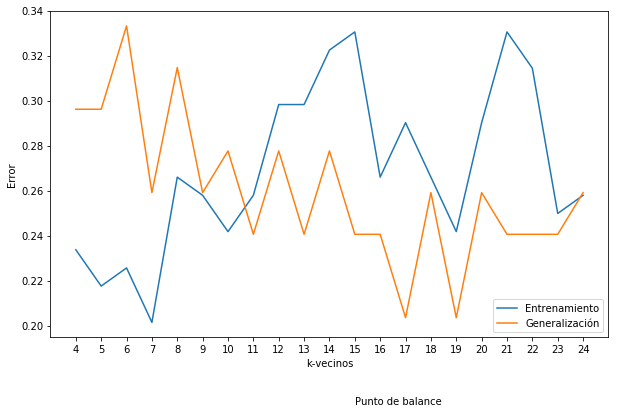

In [19]:
pl.figure(figsize = (10, 6))

pl.plot(k_values, train_error, label="Entrenamiento")
pl.plot(k_values, generalization_error, label="Generalización")
pl.xticks(k_values)
pl.xlabel("k-vecinos")
pl.ylabel("Error")
#pl.gca().invert_xaxis()
pl.arrow(13, 0.16, 0, -0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
pl.text(15, 0.165, 'Punto de balance')
pl.legend();

#### Se encuentra el optimo en 17 ya que este tiene menor complejidad que el de 19

### Reporte de medidas de precision en conjunto de pruebas

In [51]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print('Accuracy: {}'.format(knn.score(X_test, y_test)))
print('Error: {}'.format(1 - knn.score(X_test, y_test)))
y_predict = knn.predict(X_test)
print('Recall macro: {}'.format(recall_score(y_test, y_predict, average='macro')))
print('Precision macro: {}'.format(precision_score(y_test, y_predict, average='macro')))
print('F1 score: {}'.format(f1_score(y_test, y_predict, average='macro')))



Accuracy: 0.7962962962962963
Error: 0.20370370370370372
Recall macro: 0.7783068783068782
Precision macro: 0.8000000000000002
F1 score: 0.7782456140350877


#### Graficacion de margen de decision

In [39]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train, y_train)
##pl.figure(figsize = (8,16/3))    
##plot_decision_region(X[:, [0, 1]], gen_pred_fun(knn))
##plot_data(X[:, [0, 1]], y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=17, p=2,
           weights='uniform')

## Explorando la complejidad usando `DecisionTree`

### 6. Entrenamos un modelo de árbol de decisión usando los siguientes valores de profundidad:
* $[1, 2, 3, 4, 5, 7, 8, 9, 10]$
* Graficamos los errores de entrenamiento y generalización conforme a la complejidad el modelo aumenta.

In [55]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()

In [56]:
X_train, X_test, y_train, y_test = train_test_split(wine_df_full_hd, clase_arr,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=clase_arr)

In [57]:
train_error = []
generalization_error = []
max_depth_values = list(range(1, 11, 1))

for depth in max_depth_values:
    decision_tree = DecisionTreeClassifier(max_depth=depth)
    decision_tree.fit(X_train, y_train)
    train_error.append(1 - decision_tree.score(X_train, y_train))
    generalization_error.append(1 - decision_tree.score(X_test, y_test))

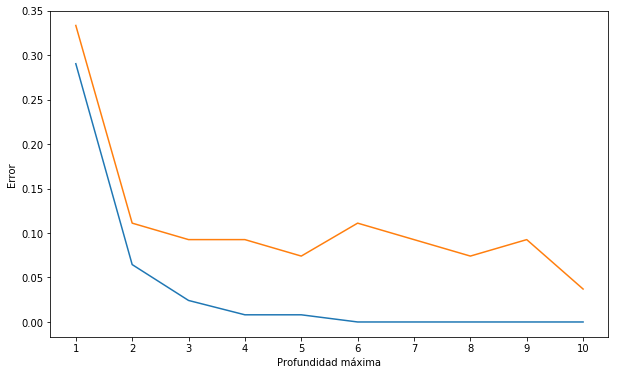

In [58]:
pl.figure(figsize = (10, 6))

pl.plot(max_depth_values, train_error, label="Entrenamiento")
pl.plot(max_depth_values, generalization_error, label="Generalización")
pl.xticks(max_depth_values)
pl.xlabel("Profundidad máxima")
pl.ylabel("Error")
pl.legend;

### 7. Construyamos un conjunto de datos usando las características `Alcalinity` contra `Malic Acid`.

* Usamos la partición 70-30 definida al inicio
* Usando `DecisionTree`, determine el número subóptimo de profundidad máxima usando evaluación de la complejidad. Use los mismos valores de $\textit{max_depth}$ : $[1, 2, 3, 4, 5, 7, 8, 9, 10]$
* Grafique la superficie de decisión contra los ejemplos de test.
* Reporte accuracy, el error de clasificación, la precisión macro, el recall macro y el F1 score macro sobre el **conjunto de prueba**.

#### Separacion por caracteristicas Alcalinity y Malic Acid

In [59]:
alcalinity= wine_df_full_hd['Alcalinity']
malic_acid = wine_df_full_hd['Malic_acid']

In [60]:
X2=[]
for i in range(len(proline)):
    X2.append([alcalinity[i], malic_acid[i] ])
X2= np.matrix(X2)

#### Particion 70-30

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X2, clase_arr,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=clase_arr)

#### Determinacion de numero optimo de la complejidad

In [70]:
train_error = []
generalization_error = []
max_depth_values = list(range(1, 11, 1))

for depth in max_depth_values:
    decision_tree = DecisionTreeClassifier(max_depth=depth)
    decision_tree.fit(X_train, y_train)
    train_error.append(1 - decision_tree.score(X_train, y_train))
    generalization_error.append(1 - decision_tree.score(X_test, y_test))

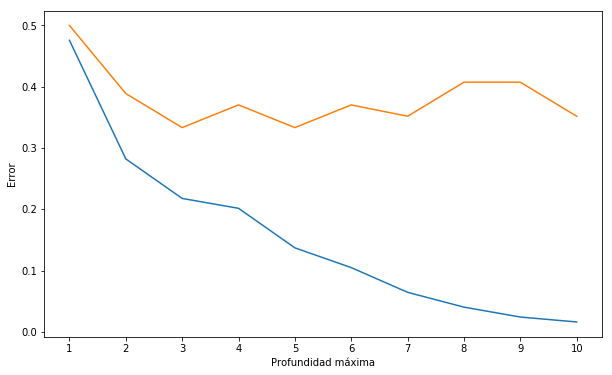

In [71]:
pl.figure(figsize = (10, 6))

pl.plot(max_depth_values, train_error, label="Entrenamiento")
pl.plot(max_depth_values, generalization_error, label="Generalización")
pl.xticks(max_depth_values)
pl.xlabel("Profundidad máxima")
pl.ylabel("Error")
pl.legend;

#### El numero optimo se encuentra en 3

### Reporte de medidas de precision en conjunto de pruebas

In [72]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

decision_tree = DecisionTreeClassifier(max_depth=3)
decision_tree.fit(X_train, y_train)

print('Accuracy: {}'.format(decision_tree.score(X_test, y_test)))
print('Error: {}'.format(1 - decision_tree.score(X_test, y_test)))
y_predict = decision_tree.predict(X_test)
print('Recall macro: {}'.format(recall_score(y_test, y_predict, average='macro')))
print('Precision macro: {}'.format(precision_score(y_test, y_predict, average='macro')))
print('F1 score: {}'.format(f1_score(y_test, y_predict, average='macro')))



Accuracy: 0.6666666666666666
Error: 0.33333333333333337
Recall macro: 0.6666666666666666
Precision macro: 0.6997385620915034
F1 score: 0.6783835595429798


## Visualización usando `DecisionTree`

### 8. Escoja el mejor modelo entrenado sobre las 13 características. Visualice el árbol de decisión.

In [78]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

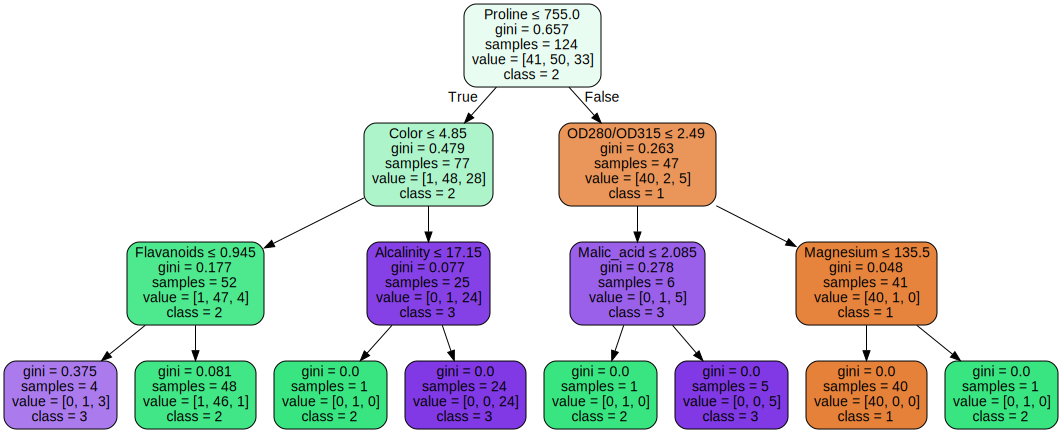

In [79]:
X_train, X_test, y_train, y_test = train_test_split(wine_df_full_hd, clase_arr,
                                                    test_size=0.3, 
                                                    random_state=1234,
                                                    stratify=clase_arr)
decision_tree = DecisionTreeClassifier(max_depth=3)
decision_tree.fit(X_train, y_train)
from IPython.display import SVG
dot_data = export_graphviz(decision_tree, out_file=None, 
                         feature_names=wine_df_full_hd.columns,  
                         class_names=["1","2","3"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)
SVG(graph.pipe(format='svg'))

In [60]:
decision_tree.feature_importances_

array([0.        , 0.02189381, 0.        , 0.        , 0.        ,
       0.        , 0.16472705, 0.        , 0.02522167, 0.3385328 ,
       0.02563178, 0.        , 0.42399287])

### 9. ¿Cuales son las características más importantes del modelo?

Las mas importante son la ultima que es Proline y  la 13 que es Color

### 10. Exprese 5 reglas de decisión con base en el árbol entrenado.


Si Proline <= 775.0 y Color <= 4.85  y Alcalinity > 17.5 pertenece a clase 2.

Si proline > 775.0 y OD280 <= 2.49 Queda como clase 1.

Si proline > 775.0 y OD280 <= 2.49 y Magnesium >135.5 se coloca en clase 2.

Si Proline <= 775.0 y Si color > 4.85  y Alcalinity <= 17.5 pertenece a clase 3.

Si Proline <= 775.0 y Color <= 4.85 y Flavanoids >0.945 pertenece a clase 3.

**Instrucciones de envío:**

Este notebook debe enviarse a través del siguiente [File Request](https://www.dropbox.com/request/BaGOOsyWbYDRQAfKRTGJ)
antes de la medianoche de la fecha límite. El archivo debe nombrarse como 
`iis-practica2-unalusername1-unalusername2.ipynb`, donde `unalusername` es el nombre de usuario asignado por la universidad (incluya los nombres de usuario de todos los miembros del grupo).